# Requirements

In [196]:
import imaplib
import email
from email import policy
import os
import pandas as pd
from email.header import decode_header
import re
from bs4 import BeautifulSoup
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import imaplib
import socket
import ssl

### Paths

In [197]:
import sys, os
sys.path.append(os.path.abspath('../../src'))
from helper_functions.path_resolver import DynamicPathResolver

In [198]:
dpr = DynamicPathResolver(marker="README.md")

raw_dir = dpr.path.data.raw._path
raw_data_path = dpr.path.data.raw.data_mail.own.mails_raw_csv
#cleaned_data_path = dpr.path.data.raw.data_mail.own.mails_cleaned_csv
labeled_data_path = dpr.path.data.raw.data_mail.own.mails_labeled_csv

Project Root: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert


### IMAP connect

In [199]:
IMAP_SERVER = "secureimap.t-online.de"
IMAP_PORT = 993

In [ ]:
EMAIL_ACCOUNT = ''
EMAIL_PASSWORD = ''

In [201]:
try:
    ipv4_address = socket.gethostbyname(IMAP_SERVER)
    print(f"Resolved IMAP Server: {IMAP_SERVER} -> {ipv4_address}")

    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = True  
    ssl_context.verify_mode = ssl.CERT_REQUIRED  

    mail = imaplib.IMAP4_SSL(IMAP_SERVER, IMAP_PORT, ssl_context=ssl_context)
    mail.login(EMAIL_ACCOUNT, EMAIL_PASSWORD)
    print("IMAP Connection Successful!")

except Exception as e:
    print(f"Error: {e}")


Resolved IMAP Server: secureimap.t-online.de -> 194.25.134.115
IMAP Connection Successful!


### Functions

In [202]:
def extract_email_address(sender):
    email_match = re.search(r'<(.+?)>', sender)
    return email_match.group(1) if email_match else sender 

In [203]:
def decode_mime_header(header_value):
    if header_value:
        decoded_parts = decode_header(header_value)
        decoded_text = []

        for part, encoding in decoded_parts:
            try:
                if isinstance(part, bytes):
                    decoded_text.append(part.decode(encoding or "utf-8", errors="replace"))  
                else:
                    decoded_text.append(part)
            except LookupError:  
                decoded_text.append(part.decode("utf-8", errors="replace"))  

        return " ".join(decoded_text)
    return "Unknown"

In [204]:
def clean_html_body(html_body):
    soup = BeautifulSoup(html_body, "html.parser")
    text = soup.get_text(separator="\n", strip=True)
    return text

In [205]:
def fetch_emails(folder, label):
    mail.select(folder)
    status, messages = mail.search(None, "ALL")
    email_ids = messages[0].split()
    email_data = []

    for email_id in email_ids:
        status, msg_data = mail.fetch(email_id, "(RFC822)")
        for response_part in msg_data:
            if isinstance(response_part, tuple):
                msg = email.message_from_bytes(response_part[1])

                print(f"Raw Subject: {msg['Subject']}")
                print(f"Decoded Subject: {decode_mime_header(msg['Subject'])}")

                # Decode headers
                subject = decode_mime_header(msg["Subject"]) or "No Subject"
                sender = decode_mime_header(msg["From"])
                sender = extract_email_address(sender)
                date = msg["Date"]
                body = ""

                # Only plain text
                if msg.is_multipart():
                    for part in msg.walk():
                        content_type = part.get_content_type()
                        content_disposition = part.get("Content-Disposition", "")

                        # Skip attachmenets
                        if content_type == "text/plain" and "attachment" not in content_disposition:
                            body = part.get_payload(decode=True).decode(errors="ignore")
                            break  
                else:
                    body = msg.get_payload(decode=True).decode(errors="ignore")

                email_data.append([label, date, sender, subject, body])

    return email_data


In [206]:
def save_to_csv(emails_data, path):
    file_exists = os.path.isfile(path)
    df = pd.DataFrame(emails_data, columns=["Label", "Date", "Sender", "Subject", "Body"])

    df.to_csv(
        path,
        mode='a',  
        header=not file_exists, 
        index=False,
        encoding="utf-8",  
        quoting=csv.QUOTE_MINIMAL, 
        quotechar='"', 
    )

    return df

In [207]:
def clean_and_save(df, save_path, filter):
    def clean_html(text):
        return BeautifulSoup(str(text), "html.parser").get_text(separator="\n", strip=True)
    
    if filter:
        df["body"] = df["body"].apply(clean_html)
        df.to_csv(save_path, index=False, encoding="utf-8")
        print(f"Cleaned dataset saved as {save_path}")


In [208]:
def label_known_legit(df, legit_senders):
    df.loc[df["sender"].isin(legit_senders), "label"] = 0
    legit_count = df["label"].value_counts().get(0, 0)
    print(f"Auto-labeled {legit_count} emails as LEGIT.")
    return df


def label_known_phish(df, spam_senders):
    df.loc[df["sender"].isin(spam_senders), "label"] = 1
    spam_count = df["label"].value_counts().get(1, 0)
    print(f"Auto-labeled {spam_count} emails as SPAM.")
    return df


def label_by_domain(df, legit_domains, spam_domains):
    df.loc[df["sender"].str.endswith(tuple(legit_domains)), "label"] = 0
    legit_count = df["label"].value_counts().get(0, 0)
    print(f"Auto-labeled {legit_count} emails as LEGIT based on domain endings.")

    df.loc[df["sender"].str.endswith(tuple(spam_domains)), "label"] = 1
    spam_count = df["label"].value_counts().get(1, 0)
    print(f"Auto-labeled {spam_count} emails as SPAM based on domain endings.")
    return df


def advanced_auto_label_emails(df, legit_senders, spam_senders, legit_domains, spam_domains, save_path):
    if "label" not in df.columns:
        df["label"] = -1  

    df = label_known_legit(df, legit_senders)
    df = label_known_phish(df, spam_senders)
    df = label_by_domain(df, legit_domains, spam_domains)

    df.to_csv(save_path, index=False, encoding="utf-8")
    print(f"Auto-labeling complete. Labeled dataset saved at: {save_path}")

    return df

In [209]:
def display_next_top_senders(df, start_index=0, batch_size=100, 
                             exclude_domain="kleinanzeigen.de",
                             known_spam=None,
                             known_legit=None,
                             legit_domains=None,
                             spam_domains=None):
    if legit_domains is None:
        legit_domains = set()
    if spam_domains is None:
        spam_domains = set()

    pd.set_option("display.max_colwidth", None)

    sorted_senders_df = df["sender"].value_counts().reset_index()
    sorted_senders_df.columns = ["Sender", "Count"]
    sorted_senders_df["Domain"] = sorted_senders_df["Sender"].str.split("@").str[-1]

    filtered_senders_df = sorted_senders_df[
        (~sorted_senders_df["Sender"].str.endswith(exclude_domain)) &  # Exclude specific domain
        (~sorted_senders_df["Sender"].isin(known_spam)) &              # Exclude known spam senders
        (~sorted_senders_df["Sender"].isin(known_legit)) &             # Exclude known legit senders
        (~sorted_senders_df["Domain"].isin(spam_domains)) &            # Exclude spam domains
        (~sorted_senders_df["Domain"].isin(legit_domains))             # Exclude legit domains
    ]

    next_senders_df = filtered_senders_df.iloc[start_index:start_index + batch_size]
    
    print(f"Remaining Unique Senders: {len(filtered_senders_df)}")
    print(f"Showing senders {start_index + 1} to {start_index + batch_size} (excluding '{exclude_domain}', known spam/legit senders, and domains)")
    print(next_senders_df["Sender"].to_string(index=False))

In [210]:
def label_senders(df, start_index=0, batch_size=1, 
                  exclude_domain="kleinanzeigen.de",
                  known_spam=None,
                  known_legit=None,
                  legit_domains=None,
                  spam_domains=None):
    if known_spam is None:
        known_spam = set()
    if known_legit is None:
        known_legit = set()
    if legit_domains is None:
        legit_domains = set()
    if spam_domains is None:
        spam_domains = set()

    pd.set_option("display.max_colwidth", None)

    sorted_senders_df = df["sender"].value_counts().reset_index()
    sorted_senders_df.columns = ["Sender", "Count"]
    sorted_senders_df["Domain"] = sorted_senders_df["Sender"].str.split("@").str[-1]

    filtered_senders_df = sorted_senders_df[
        (~sorted_senders_df["Sender"].str.endswith(exclude_domain)) &  
        (~sorted_senders_df["Sender"].isin(known_spam)) &              
        (~sorted_senders_df["Sender"].isin(known_legit)) &             
        (~sorted_senders_df["Domain"].isin(spam_domains)) &            
        (~sorted_senders_df["Domain"].isin(legit_domains))             
    ]

    while start_index < len(filtered_senders_df):
        sender_row = filtered_senders_df.iloc[start_index]
        sender = sender_row["Sender"]
        print(f"Sender: {sender} ({sender_row['Count']} emails)")

        user_input = input("Label as Phish (1) or Legit (0): ").strip()
        if user_input == "1":
            df.loc[df["sender"] == sender, "label"] = "phish"
            known_spam.add(sender)
            print(f"Labeled {sender} as Phish.")
        elif user_input == "0":
            df.loc[df["sender"] == sender, "label"] = "legit"
            known_legit.add(sender)  # This will now work correctly
            print(f"Labeled {sender} as Legit.")
        else:
            print("Invalid input, try again.")
            continue

        start_index += 1
        print(f"Processed {start_index}/{len(filtered_senders_df)} senders.\n")

    print("All senders processed.")


In [211]:
def concat_and_save(csv_path1, csv_path2, output_dir, output_filename="combined_own.csv"):
    df1 = pd.read_csv(csv_path1)
    df2 = pd.read_csv(csv_path2)
    combined_df = pd.concat([df1, df2], ignore_index=True)

    if 'label' not in combined_df.columns:
        raise ValueError("Column 'label' not found in CSV files.")

    class_distribution = combined_df['label'].value_counts()
    print("\nClass Distribution:")
    print(class_distribution)

    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_filename)
    combined_df.to_csv(output_path, index=False)

    print(f"\nCombined dataset saved at: {output_path}")

    plt.figure(figsize=(6, 4))
    sns.barplot(x=class_distribution.index, y=class_distribution.values)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.show()

    return combined_df

In [212]:
def replace_labels_and_save(csv_path):
    df = pd.read_csv(csv_path)

    if 'label' not in df.columns:
        raise ValueError("Column 'label' not found in CSV file.")

    df['label'] = df['label'].replace({'legit': 0, 'phishing': 1})
    df.to_csv(csv_path, index=False)


### Get all folders

In [213]:
status, folders = mail.list() 
print("Available IMAP Folders:")
for folder in folders:
    print(folder.decode()) 

Available IMAP Folders:
(\HasChildren) "." INBOX
(\HasNoChildren \UnMarked) "." "INBOX.G DATA Software AG"
(\HasNoChildren \UnMarked) "." INBOX.I-Schule
(\HasNoChildren \UnMarked) "." INBOX.LBS_Sparkasse
(\HasNoChildren \UnMarked) "." INBOX.Archive
(\HasNoChildren \UnMarked) "." INBOX.Steuer
(\HasNoChildren \UnMarked) "." INBOX.Telekom
(\HasNoChildren \UnMarked) "." INBOX.bestellungen
(\HasNoChildren \UnMarked \Junk) "." INBOX.Spam
(\HasNoChildren \UnMarked) "." INBOX.PayPal
(\HasNoChildren \UnMarked) "." "INBOX.Wohnung Altlu&AN8-heim"
(\HasNoChildren \Trash) "." INBOX.Trash
(\HasNoChildren \UnMarked \Sent) "." INBOX.Sent
(\HasNoChildren \Drafts) "." INBOX.Drafts


### Fetch Raw Mails & Save

In [165]:
get_all = True
all_emails = []

In [166]:
if get_all:
    for folder in folders:
        folder_name = folder.decode().split(' "." ')[-1]  
        print(f"Processing folder: {folder_name}")

        if folder_name == "INBOX":
            label = -1
        elif "Spam" in folder_name:
            label = 1  
        elif "Sent":
            label = 0
        elif "Drafts":
            label = 0
        elif "Trash":
            label = 0
        else:
            label = 0  

        emails = fetch_emails(folder_name, label)
        all_emails.extend(emails)

    df_all = save_to_csv(all_emails, raw_data_path)
    print(f"Saved {len(df_all)} emails to mails_raw.csv")

Processing folder: INBOX
Raw Subject: Fw: AW: (#18215010) Wechsel 408996239
Decoded Subject: Fw: AW: (#18215010) Wechsel 408996239
Raw Subject: Autoreply: Kd-Nr. 5.6003.381367.3
Decoded Subject: Autoreply: Kd-Nr. 5.6003.381367.3
Raw Subject: =?iso-8859-1?Q?Terminbest=E4tigung_zum_Thema_Sparen_und_Anlegen?=
Decoded Subject: Terminbestätigung zum Thema Sparen und Anlegen
Raw Subject: Wenn Sie mit dem Auto unterwegs sind und Hilfe brauchen
Decoded Subject: Wenn Sie mit dem Auto unterwegs sind und Hilfe brauchen
Raw Subject: Gelesen: Eugenia Kohl BSV - 6296061021
Decoded Subject: Gelesen: Eugenia Kohl BSV - 6296061021
Raw Subject: Ihr Feedback zum Service der IKK classic
Decoded Subject: Ihr Feedback zum Service der IKK classic
Raw Subject: =?UTF-8?q?Nach_der_Bundestagswahl:_Wir_k=C3=A4mpfen_weiter_f=C3=BCr_bedro?=
 =?UTF-8?q?hte_Journalist*innen_und_f=C3=BCr_die_Pressefreiheit?=
Decoded Subject: Nach der Bundestagswahl: Wir kämpfen weiter für bedrohte Journalist*innen und für die Pressefr

### Clean mails

##### Load raw

In [183]:
raw_df = pd.read_csv(raw_data_path)
print(f"Total emails: {len(raw_df)}")
print(raw_df["label"].value_counts()) 

Total emails: 940
label
 0    931
-1      9
Name: count, dtype: int64


##### Clean HTML

In [184]:
clean_and_save(raw_df, cleaned_data_path, filter=True)

C:\Users\ilian\AppData\Local\Temp\ipykernel_25148\1715429197.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(str(text), "html.parser").get_text(separator="\n", strip=True)


Cleaned dataset saved as C:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert\data\raw\data_mail\own\mails_cleaned.csv


### Label

##### Load cleaned

In [185]:
cleaned_df = pd.read_csv(cleaned_data_path)
print(f"Total emails: {len(cleaned_df)}")
print(cleaned_df["label"].value_counts()) 

Total emails: 940
label
 0    931
-1      9
Name: count, dtype: int64


##### Load to label

In [ ]:
to_label_df = pd.read_csv(labeled_data_path) # cleaned_data_path
print(f"Total emails: {len(to_label_df)}")
print(to_label_df["label"].value_counts()) 

##### Auto label

In [ ]:
legit_senders = [
    "hallo@news.golfandwellness.eu",
    "noreply@ebay-kleinanzeigen.de",
    "ebay@ebay.com",
    "ebay@reply.ebay.de",
    "ebay@ebay.de",
    "noreply@kleinanzeigen.de",
    "service@paypal.de",
    "info@customer.autobutler.de",
    "mail@newsletterdirekt24.eu",
    "newsletter@news.blume2000.de",
    "info@fuxtec.de",
    "news@esyoil.com",
    "no-reply@m.enpal.de",
    "noreply@mail.kleinanzeigen.de",
    "newsletter@yatego.com",
    "tipp@letter.info-letter.de",
    "info@go.knauf.com",
    "reminders@facebookmail.com",
    "ebay@noreply1.ebay.com",
    "carolina@m.enpal.de",
    "no-reply@info.enpal.de",
    "noreply@alditalk-kundenbetreuung.de",
    "info@newsletter.agrar-fachversand.com",
    "info@nl.umweltbote.de",
    "ebay@info.ebay.de",
    "bestaetigung@news.blume2000.de",
    "ebay@reply2.ebay.de",
    "no-reply@rtm.autoscout24.com",
    "kundenservice@photovoltaik-angebotsvergleich.de",
    "invite@information.ebay-kleinanzeigen.de",
    "onlineshop@mediamarkt.de",
    "no_reply@communications.paypal.com",
    "noreply@service.dpd.de",
    "noreply@go.knauf.com",
    "a.berger@sonnenrose-solar.de",
    "friendsuggestion@facebookmail.com",
    "info@agrar-fachversand.com",
    "noreply@google.com",
    "david@m.enpal.de",
    "shop@reben.de",
    "bruder@bruderimmobilien.de",
    "noreply@hausfrage.de",
    "info@febesol.de",
    "neu@web.de",
    "info@hanstischer.de",
    "service@blume2000.de",
]


likely_spam_senders = [
    "Gummies@playsstar.com",
    "Escooter@playsstar.com",
    "iPad@playsstar.com",
    "Nuubu@playsstar.com",
    "limpado@mx-srv-016.de",
    "liebesfun@mx-srv-040.de",
    "liebesfun@mx-srv-026.de",
    "liebesfun@mx-srv-025.de",
    "liebesfun@mx-srv-034.de",
    "liebesfun@mx-srv-009.de",
    "liebesfun@mx-srv-007.de",
    "liebesfun@mx-srv-016.de",
    "liebesfun@mx-srv-030.de",
    "liebesfun@mx-srv-002.de",
    "liebesfun@mx-srv-019.de",
    "liebesfun@mx-srv-010.de",
    "limpado@mx-srv-027.de",
    "986280d3f2584c768811+dak@mailspons.com",
    "0a63ecfec3094cc6a03b+support@mailspons.com",
    "0a63ecfec3094cc6a03b+adac_support@mailspons.com",
    "986280d3f2584c768811+olan@mailspons.com",
    "compania-4dac6f1011zzz@mailslurp.info",
    "support+kokocava@mailslurp.biz",
    "support+camsytar@mailslurp.biz",
    "collect-throughout@hjcandnz.mailosaur.net",
    "thread-fell@ccea2dbn.mailosaur.net",
    "through-neck@mmc5fiya.mailosaur.net",
    "a598d50c-1c3b-444b-8b03-cd8e4511ca05@mailslurp.biz",
    "e5bdb345-3f16-436e-9b0d-b8702ed1723b@mailslurp.biz",
    "neu@mailings.web.de",
    "info@spar-mehr.com",
    "mail@spar-highlight.de",
    "mail@mailings.bestrelationsdigital.de",
    "Abderrafia.Moutei@ac-grenoble.fr",
    "khomasy9@gmail.com",
    "nathalie.appelt@gmx.de",
    "ebay@andopen.co",
    "service@hexanet.fr",
    "no-reply@mail.instagram.com",
    "csfeedback@go.ebay.com",
    "noreply@zeitgreen.mailing.zeit.de",
    "patrickhilbert@gmx.de",
    "no-reply@wienerlinien.at",
    "data-protection@rhodius-abrasives.com",
    "orders@maverickdistributing.com",
    "Unicomments@nbcuni.com",
    "kundenservice@movenience.nl",
    "no-reply@freecme.com",
    "no-reply@steuerbot.com",
    "patrick.kelley@birdvilleschools.net",
    "d.grebenstein@gmx.net",
    "no-reply@dice.com",
    "no-reply@mail.instagram.com",
    "notification@facebookmail.com",
    "uwe.rosenkranz@t-online.de",
    "no-reply@accounts.google.com",
    "noreply@egym.de",
    "newsletter@news.lascana.de",
    "newsletter@lifestylehotels.net",
    "newsletter@info.infomachdichfertig.co.uk.de",
    "optin@regenbogen-news.de",
    "news@nl.meintierportal.de",
    "no-reply@leads.autoscout24.com",
    "news@news.conrad.at",
    "newsletter@gmail.com",
    "newsletter@cobradental.co.id",
    "newsletter@inter.xosy.thirtyfiveseven.com.de",
    "newsletter@gdk1h.nl",
    "newsletter@m-highlight.com",
    "news@crm.orellfuessli.ch",
    "news@int-jdsports.com",
    "newsletter@news.lascana.de",
    "news@nl.meintierportal.de",
    "newsletter@iconicone.online",
    "news@int-jdsports.com",
    "news@nl.meintierportal.de",
    "news@news.conrad.at",
    "info@your-emotion.eu",
    "info@reha-med.de",
    "info@fitnessass.eu",
    "info@putainde.live",
    "info@flirtcountry.live",
    "info@relations-locator.org",
    "info@ropes-and-slopes.live",
    "info@magic-mob.com",
    "info@joy-virtual.live",
    "info@badasstrain.com",
    "info@turnmeonn.com",
    "info@notification-post.live",
    "info@lustfulcloud.art",
    "info@singlesfinders.art",
    "info@cupidforyou.live",
    "info@stripforlikes.live",
    "info@flirtmeyou.live",
    "info@cordialmeeting.live",
    "info@gorgeous-lady.live",
    "info@helloogirl.live",
    "info@penetrationn.live",
    "info@secondturn.eu",
    "info@kittydate.live",
    "info@silknettie.eu",
    "info@zartheit.live",
    "info@intimacy-connects.live",
    "info@meet-4u-lady.live",
    "info@putainde.live",
    "vQVOcoZ@smart-isp.org.uk",
    "PDGszDT@smart-isp.org.uk",
    "info@hungrychica.com",
    "C+Performance.711@smart-isp.org.uk",
    "noreply@rustano.eclub.se",
    "K2DietLionsDen@et.uber.com",
    "info@silknettie.eu",
    "Welt-Newspoint@smart-isp.org.uk",
    "uxCWPIw@smart-isp.org.uk",
    "CuVKHGn@smart-isp.org.uk",
    "fmqknvE@smart-isp.org.uk",
    "hQmPCXl@smart-isp.org.uk",
    "XjCjSGM@smart-isp.org.uk",
    "YSnwCKe@smart-isp.org.uk",
    "YAWeNTU@treuewidmen.autos",
    "JJTltbL@treuewidmen.autos",
    "info@wetactivity.com",
    "Paketverfolgungonlineservice.7389016@treuewidmen.autos",
    "FigurKapseln9042924@smart-isp.org.uk",
    "Paketverfolgungonlineservice.1916405@smart-isp.org.uk",
    "UUKbECp@treuewidmen.autos",
    "ODNdTlm@smart-isp.org.uk",
    "SoSxkMh@treuewidmen.autos",
    "cdYFEBT@smart-isp.org.uk",
    "viPVJTZ@treuewidmen.autos",
    "tzEfkmr@smart-isp.org.uk",
    "info@penetrationn.live",
    "ZIETqHt@smart-isp.org.uk",
    "ZMsBxEl@smart-isp.org.uk",
    "info@vibranthot.live",
    "FigurKapseln3412189@smart-isp.org.uk",
    "r6og1.Energie@ISP-inteligente.com",
    "Paketverfolgungonlineservice.9606376@smart-isp.org.uk",
    "info@zartheit.live",
    "Paketverfolgungonlineservice.4535622@smart-isp.org.uk",
    "LrYshRE@smart-isp.org.uk",
    "uDKOFXC@treuewidmen.autos",
    "yyUHYFY@smart-isp.org.uk",
    "info@fitnessass.eu",
    "udiHXXt@treuewidmen.autos",
    "XgjrJyo@treuewidmen.autos",
    "DDhcTFq@treuewidmen.autos",
    "WMtBRWO@treuewidmen.autos",
    "nuHkDqh@smart-isp.org.uk",
    "RxXXTlP@treuewidmen.autos",
    "noreply@cityof-pleasure.live",
    "lgIUCDg@smart-isp.org.uk",
    "info@notification-post.live",
    "info@lustfulcloud.art",
    "info@singlesfinders.art",
    "info@cupidforyou.live",
    "info@stripforlikes.live",
    "info@flirtmeyou.live",
    "info@cordialmeeting.live",
    "info@gorgeous-lady.live",
    "info@helloogirl.live",
    "info@turnmeonn.com",
    "info@wetactivity.com",
    "info@intimacy-connects.live",
    "info@meet-4u-lady.live",
    "info@hungrychica.com",
    "info@vibranthot.live",
    "info@penetrationn.live",
    "info@zartheit.live",
    "info@secondturn.eu",
    "info@kittydate.live",
    "info@silknettie.eu",
    "info@putainde.live",
    "vQVOcoZ@smart-isp.org.uk",
    "PDGszDT@smart-isp.org.uk",
    "info@hungrychica.com",
    "C+Performance.711@smart-isp.org.uk",
    "noreply@rustano.eclub.se",
    "K2DietLionsDen@et.uber.com",
    "info@silknettie.eu",
    "Welt-Newspoint@smart-isp.org.uk",
    "uxCWPIw@smart-isp.org.uk",
    "CuVKHGn@smart-isp.org.uk",
    "fmqknvE@smart-isp.org.uk",
    "hQmPCXl@smart-isp.org.uk",
    "XjCjSGM@smart-isp.org.uk",
    "YSnwCKe@smart-isp.org.uk",
    "YAWeNTU@treuewidmen.autos",
    "JJTltbL@treuewidmen.autos",
    "info@wetactivity.com",
    "Paketverfolgungonlineservice.7389016@treuewidmen.autos",
    "FigurKapseln9042924@smart-isp.org.uk",
    "Paketverfolgungonlineservice.1916405@smart-isp.org.uk",
    "UUKbECp@treuewidmen.autos",
    "ODNdTlm@smart-isp.org.uk",
    "SoSxkMh@treuewidmen.autos",
    "cdYFEBT@smart-isp.org.uk",
    "viPVJTZ@treuewidmen.autos",
    "tzEfkmr@smart-isp.org.uk",
    "info@penetrationn.live",
    "ZIETqHt@smart-isp.org.uk",
    "ZMsBxEl@smart-isp.org.uk",
    "info@vibranthot.live",
    "FigurKapseln3412189@smart-isp.org.uk",
    "r6og1.Energie@ISP-inteligente.com",
    "Paketverfolgungonlineservice.9606376@smart-isp.org.uk",
    "info@zartheit.live",
    "Paketverfolgungonlineservice.4535622@smart-isp.org.uk",
    "LrYshRE@smart-isp.org.uk",
    "uDKOFXC@treuewidmen.autos",
    "yyUHYFY@smart-isp.org.uk",
    "info@fitnessass.eu",
    "udiHXXt@treuewidmen.autos",
    "XgjrJyo@treuewidmen.autos",
    "DDhcTFq@treuewidmen.autos",
    "WMtBRWO@treuewidmen.autos",
    "nuHkDqh@smart-isp.org.uk",
    "RxXXTlP@treuewidmen.autos",
    "noreply@cityof-pleasure.live",
    "lgIUCDg@smart-isp.org.uk",
    "nitroman@3219.com",
    "gaspo@stavropol-diplomy.ru",
    "cafe@fotostrana.ru",
    "stefan.altmann2119527@aegsite.space",
    "esCPWwC@smart-isp.org.uk",
    "ilyanas@gmx.net",
    "Paketverfolgungonlineservice.0204131@smart-isp.org.uk",
    "thomas.hahn.9452212@acomtx.work",
    "Paketverfolgungonlineservice.4847071@smart-isp.org.uk",
    "DNWw1.Energie@ISP-inteligente.com",
    "FigurKapseln8461767@treuewidmen.autos",
    "email@dfds.info",
    "C+Performance.117@smart-isp.org.uk",
    "Paketverfolgungonlineservice.4196697@treuewidmen.autos",
    "QdpcGIz@smart-isp.org.uk",
    "info@turnmeonn.com",
    "l37zP.Energie@ISP-inteligente.com",
    "Paketverfolgungonlineservice.5648026@smart-isp.org.uk",
    "keineantwortadresse@web.de",
    "FigurKapseln9809221@treuewidmen.autos",
    "info@sacred-feeling.live",
    "thomas.hahn.3243646@mrswgo.work",
    "orders@maverickdistributing.com",
    "info@stripforlikes.live",
    "Thomas.hahn2961120@bwwnews.xyz",
    "FigurKapseln7250624@treuewidmen.autos",
    "hans.slegers@treuewidmen.auto",
    "Paketverfolgungonlineservice.2256182@smart-isp.org.uk",
    "news@int-jdsports.com",
    "info@flirtmeyou.live",
    "Paketverfolgungonlineservice.2436980@smart-isp.org.uk",
    "info@cordialmeeting.live",
    "9BoV6.Energie@ISP-inteligente.com",
    "stefan.altmann2230985@cvvlnk.xyz",
    "noreply@zeitgreen.mailing.zeit.de",
    "FaLaFxj@smart-isp.org.uk",
    "C+Performance.725@aerzteblat.click",
    "stefan.altmann7998277@ntthost.xyz",
    "radisize@gmx.net",
    "Paketverfolgungonlineservice.0674794@smart-isp.org.uk",
    "team@smart-isp.org.uk",
    "Paketverfolgungonlineservice.9080992@treuewidmen.autos",
    "Paketverfolgungonlineservice.5658075@smart-isp.org.uk",
    "Unicomments@nbcuni.com",
    "FigurKapseln0086286@smart-isp.org.uk",
    "stefan.altmann7225759@adgsite.cyou",
    "HtmCpAJ@treuewidmen.autos",
    "pcSleKt@smart-isp.org.uk",
    "news@crm.orellfuessli.ch",
    "SphHHJa@smart-isp.org.uk",
    "FigurKapseln6614463@smart-isp.org.uk",
    "jwrOISy@smart-isp.org.uk",
    "FyjdOmz@smart-isp.org.uk",
    "noreply@privateroomshere.live",
    "petra@waehle-selbst.com",
    "C+Performance.214@smart-isp.org.uk",
    "00f5ea6bdc79cd307c3f@members.ebay.com",
    "IUlnuvo@smart-isp.org.uk",
    "cwVsJOA@smart-isp.org.uk",
    "jfYAlJW@smart-isp.org.uk",
    "bhati8767@gmail.com",
    "FigurKapseln2121344@aerzteblat.click",
    "newsletter@news.lascana.de",
    "patrickhilbert@gmx.de",
    "ebay@reply2.ebay.fr",
    "csfeedback@go.ebay.com",
    "sVJadkf@smart-isp.org.uk",
    "Paketverfolgungonlineservice.9584926@smart-isp.org.uk",
    "NHvjTPj@treuewidmen.autos",
    "KncoOrZ@smart-isp.org.uk",
    "uBzfZaA@smart-isp.org.uk",
    "Nitroman@2465.com",
    "0b5d100a2ac50ac3c639@members.ebay.com",
    "info@gorgeous-lady.live",
    "Paketverfolgungonlineservice.4275482@smart-isp.org.uk",
    "bCiysAg@smart-isp.org.uk",
    "WioxxSz@infoauswaertiges-amt.com",
    "Casino4you2023@3718.com",
    "info@luar-biasa.live",
    "Gesundheits-News@44162.com",
    "C+Performance.403@smart-isp.org.uk",
    "C+Performance.588@treuewidmen.autos",
    "newsletter@lifestylehotels.net",
    "hellos_ly5749qd@members.ebay.com.hk",
    "optin@regenbogen-news.de",
    "mail@lottomail-info.com",
    "FigurKapseln0484237@smart-isp.org.uk",
    "lorenz_conny@gmx.at",
    "Paketverfolgungonlineservice.1751588@smart-isp.org.uk",
    "FigurKapseln2504703@smart-isp.org.uk",
    "Paketverfolgungonlineservice.7895539@smart-isp.org.uk",
    "Paketverfolgungonlineservice.2962999@smart-isp.org.uk",
    "info@helloogirl.live",
    "susan.heat@gmx.net",
    "robin.schad99@gmx.de",
    "willi.mertes@gmx.net",
    "kKFPBrT@smart-isp.org.uk",
    "saymee@gmx.de",
    "1poiuztrewq@gmx.at",
    "QGyEIMz@smart-isp.org.uk",
    "newsletter@inter.xosy.thirtyfiveseven.com.de",
    "franck_justina@jurait.de",
    "no-reply@slutsangels.live",
    "rechnungonline@web.de",
    "magdelena_frenz@jurait.de",
    "michael_uhlenbrock@pthost.ru",
    "info@notification-post.live",
    "wild.jean.pascal@pthost.ru",
    "beatrix_rosenberg@pthost.ru",
    "info@lustfulcloud.art",
    "info@singlesfinders.art",
    "gregloren.loanfirm2@gmail.com",
    "fmhqboqdw@gmail.com",
    "dunke_jovan@jurait.de",
    "weissmann_schlag@jurait.de",
    "haasnerbelinda@jurait.de",
    "info@kittydate.live",
    "ramroum90@mail.ru",
    "patrick.kelley@birdvilleschools.net",
    "heinig.sandro@pthost.ru",
    "info@incognitolife.eu",
    "info@noreplys-info.live",
    "duenhfrmahd@gmail.com",
    "cavapiyotiopb@gmx.net",
    "tipp@mails.newsletter-angebot24.de",
    "elber@afatel.pe",
    "noreply@steuerbot.com",
    "klantenservice@movenience.nl",
    "info@selection-private-free.live",
    "ilershihoviezq@gmx.net",
    "willconnbuleoyf@gmx.net",
    "teegiyosequiip@gmx.net",
    "anylgogubuchsdy@gmx.net",
    "cauharsabenewsho@gmx.net",
    "tertinjitabn3@gmx.de",
    "botroniaong3@gmx.de",
    "contacto@skiantuco.cl",
    "patrickstrootman77@gmail.com",
    "trapatdzuketipy@gmx.net",
    "usksenyokulunky@gmx.net",
    "modenikucof1c@gmx.net",
    "no-reply@freecme.com",
    "medical@hgh-group.eu",
    "julanmarshall.lawenforcement@gmail.com",
    "hussainimohammed365@gmail.com",
    "tipp@letter.digital-encoding.de",
    "info@flirtcountry.live",
    "medical@lCqg-group.eu",
    "contact@HCrifZVXy.com",
    "info@secondturn.eu",
    "pigtheoyogucon8v@gmx.net",
    "tertiesakuwood5r@gmx.de",
    "info@formationmail.art",
    "karlfriedrich_schwerdtfeger@jurait.de",
    "newsletter@gdk1h.nl",
    "newsletter@gmail.com",
    "newsletter@cobradental.co.id",
    "info@cupidforyou.live",
    "news@news.conrad.at",
    "info@web.de",
    "lbebat@gmail.com",
    "info@isgroupe.com",
    "info@meet-4u-lady.live",
    "barmomskerucuekv@gmx.de",
    "techrokihisaios@gmx.de",
    "mairizumokingub@gmx.de",
    "anconbeyativ3@gmx.de",
    "info@lusty-points.live",
    "enwiseiboiz7@gmx.de",
    "breakbodzukubiojg@gmx.de",
    "portmieruciant@gmx.de",
    "beaucatomiwhistzw@gmx.net",
    "sultscolhihanonpbj@gmx.net",
    "chanlypanforfb@gmx.net",
    "noreply@hereyes.live",
    "HegDAMF@grorechtliche.info",
    "juliamartinalisa@gmx.de",
    "gerardo.valido@gmx.at",
    "info@intimacy-connects.live",
    "stefan.altmann1178052@anfdlk.xyz",
    "NcPlstY@smart-isp.org.uk",
    "JEfnxbk@treuewidmen.autos",
    "info@lensvision.ch",
    "stefan.altmann4286069@tycloud.xyz",
    "lionel_singer@roxham.de",
    "stefan.altmann1949527@adtlnk.work",
    "best-pair@fotostrana.ru",
    "nitroman@4174.com",
    "hakan.erci@3way.ch",
    "C+Performance.350@smart-isp.org.uk",
    "data-protection@rhodius-abrasives.com",
    "noreply@sweetdeal.dk",
    "nitroman@5485.com",
    "FigurKapseln2712393@smart-isp.org.uk",
    "nitrowomen@6649.com",
    "cfpkxPu@smart-isp.org.uk",
    "noreply@wienerlinien.at",
    "emilianhecht@lavinseafood.com",
    "singlesday@nl.you-buy.net",
    "lilli.imhof@pthost.ru",
    "lucas.schledorn@jurait.de",
    "srv@list.lisi-group.com",
    "info@name-books.com",
    "anna-haberbosch@jurait.de",
    "info@secret-mailoffice.art",
    "Stephan.Ziegler.22327749@mktobin.work",
    "buechel.diethard@jurait.de",
    "info@nl.youbuy.com",
    "bus_soeren@jurait.de",
    "newsletter@info.infomachdichfertig.co.uk.de",
    "lionelbehr@thaisalespage.com",
    "thomas.hahn3785155@axevset.work",
    "awayeo20@gmail.com",
    "info@sensesfor-you.com",
    "nesletter@carcomfort.nl",
    "pospos2011@gmx.de",
    "xezaarts@gmx.de",
    "giegmdgmtuiz@gmail.com",
    "llmnelsons@lumos.net",
    "enootrori1978@gmx.de",
    "heiko.goellnitz@gmx.de",
    "b.hmayed@gmx.de",
    "giesingo@web.de",
    "kvamg@web.de",
    "cjoch1@web.de",
    "sergekouakoukouassi@gmail.com",
    "info.linkplc@gmail.com",
    "rolongrogiwin6b@web.de",
    "anjahustede@web.de",
    "zeki.koppmann@gmx.de",
    "inenkoshiirq9@gmx.net",
    "gieperpiarep1974@gmx.de",
    "medical@shbx-group.eu",
    "reidorpaca1974@gmx.net",
    "ciovangode1981@gmx.net",
    "info@touch-her.live",
    "sauvitagebusjj@gmx.net",
    "cardslimdeshiposty8@gmx.net",
    "poahighsanet8t@gmx.net",
    "sarepukumingoa@gmx.net",
    "habepakudrog4i@gmx.net",
    "info@iconofmate.com",
    "sjauvin@upa.qc.ca",
    "vernizenqui6j@gmx.net",
    "adezkekiworkop@gmx.net",
    "mamyrwaienvo@gmx.net",
    "help@cambly.com",
    "info@summermovements.com",
    "abinzaiblogzm@gmx.net",
    "kingbannakacumpxv@web.de",
    "tunsaddyakipie1l@web.de",
    "arno15@web.de",
    "info@saisittica.it",
    "jonathan.hailemichael@web.de",
    "info@badasstrain.com",
    "andreaolschewski@gmx.de",
    "feetworld@gmx.de",
    "paulitanztab@web.de",
    "pepiotto@gmx.de",
    "vin.doka@gmx.at",
    "dennis.deleski@gmx.de",
    "kati.danzer@gmx.de",
    "kevindulz@gmx.de",
    "zombiedeath@gmx.ch",
    "ma.bauer@benz-baustoffe.de",
    "jonas.dreistein@gmx.de",
    "anthony.yaovi@gmx.net",
    "vanessa12345w@gmx.de",
    "levihornung@visssible.com",
    "swelja.fls@gmx.de",
    "paddi619@web.de",
    "motownsounds@web.de",
    "schlottmanndaniel@web.de",
    "kevin.03185@web.de",
    "jennysiebertz@web.de",
    "info@cremadora.live",
    "postnl-servicedesk@0nl.online",
    "aktiongegendenhunger@nl.ab-auf-das-schiff.de",
    "stayfriends@nl.hotel24.eu",
    "info@blutdruckoptimal.com",
    "C+Performance.670@smart-isp.org.uk",
    "Deutschland@nl.tech-bild.de",
    "bestsparen@nl.reisemagazin.de",
    "newsletter@m-highlight.com",
    "news@nl.meintierportal.de",
    "Flugreisen@nl.xxl-berater.de",
    "optik@nl.styles.de",
    "Flugreisen@nl.travelgy.com",
    "no-reply@mywebsite-editor.com",
    "Lottoland@nl.avant-shop.net",
    "portal@muth-immo.de",
    "Lottoland@nl.top-umfrage.de",
    "parship@nl.reisemagazin.de",
    "inside@nl.mein-check.com",
    "customer-service@nl.ab-auf-das-schiff.de",
    "Mailer-Daemon@diplom54.ru",
    "info@magic-mob.com",
    "story@nl.kredit-vergleichen.online",
    "foodfans@nl.genussgourmet.net",
    "marina@kouch-stilist.ru",
    "noreply@swing-zone.com",
    "angebote@nl0.trip.de",
    "standler@gmx.de",
    "info@nl0.trip.de",
    "carcredit@nl.motormagazin.com",
    "TARGOBANK@nl.reisemagazin.de",
    "TARGOBANK@nl0.kredit24.com",
    "angebote@nl.trip.de",
    "customer-service@nl.trend-umfrage.com",
    "Dieter.Kirchner4913521@ankito.xyz",
    "mitteilung@nl.lami24.de",
    "mailings@nl.buero-bedarf.net",
    "info@promaster-msg.live",
    "admin@gibmirsex.com",
    "inside@nl.reisemagazin.de",
    "noreply@fpz.de",
    "info@hsr-europe.eu",
    "mitteilung@nl.trip.de",
    "message@nl.lami24.de",
    "kenniel.solomon@williamknibb.org",
    "ubgulisul@gmail.com",
    "Muenzsammler@nl.mycheck.de",
    "telekom@nl.fly24.com",
    "mitteilung@nl.moneycourier.com",
    "skg@lafh.org",
    "info@sendmenews.live",
    "info@flashingpanties.eu",
    "z@proton-m03.sarbc.ru",
    "Thomas.ehrlich5481616@rifsgo.xyz",
    "Stefan-Schubert6786126@meggod.xyz",
    "mail@sparermailing.de",
    "inside@nl0.trip.de",
    "bestsparen@nl.mycheck.de",
    "helenplums@hotmail.com",
    "Stefan-Schubert1081211@sortgo.xyz",
    "vicenta_1980@hotmail.com",
    "dominik-schroeder@ziegel.de",
    "gl-alves@hotmail.com",
    "masoto17@hotmail.com",
    "janowski@zzbudowlani.pl",
    "tuesdee@hotmail.com",
    "cmDxiJh@smart-isp.org.uk",
    "do-not-reply@propertypal.com",
    "exsopetajectkl@gmx.net",
    "Sabine-Valerie.Dominique@ac-orleans-tours.fr",
    "prohorrokumish@gmx.net",
    "tipsperowadiczv@gmx.net",
    "ciuheeninrest70@gmx.net",
    "inrikurapretbs@gmx.net",
    "info@joy-virtual.live",
    "tomtomder2@gmx.net",
    "imbesdasuspenzi@gmx.net",
    "bounce@m-budget-mobile.mobi",
    "tockcasyakilesspd@gmx.net",
    "diosingresanawx@web.de",
    "mithat.uenal@web.de",
    "gdukhorn@web.de",
    "telekom@nl.trip.de",
    "mikeanthony@holvxprint.com",
    "ref88237348378389@t-online.de",
    "ADAC-Support@mailslurp.biz",
    "liebesfun@mx-srv-013.de",
    "stanley.chang@unitedmortgageplus.com",
    "liebesfun@mx-srv-020.de",
    "no-reply@accounts.google.com",
    "hallo@news.all-about-money.net",
    "uwe.rosenkranz@t-online.de",
    "no-reply@mail.instagram.com",
    "notification@facebookmail.com",
    "angebot@news.techfever.de",
    "contact@news.nourishthinvitality.com",
    "info@mail.traveldeal.nl",
    "noreplay@dytxd.www.kirche-badsachsa.de",
    "ADAC-TEAM-@mailslurp.biz",
    "Keto-power-x@mailslurp.biz",
    "IPTV-STRONGER@mailslurp.biz",
    "adac-kundenservice@mailslurp.biz",
    "atmnews@info.atm-newsletter24.de",
    "mail@mailing.betterfly-leads-angebote.de",
    "shine-brief@mmc5fiya.mailosaur.net",
    "facts@nl.kredit24.com",
    "optik@nl.mycheck.de",
    "info@harlotlocatrs.live",
    "info@b7mailing.com",
    "bestsparen@nl.elektro-mobil.net",
    "events@lafh.org",
    "info@fastheart-connect.eu",
    "sh-ruba@scs-net.org",
    "dave@cadamedia.ie",
    "k_nadin@i.ua",
    "latest@nl.premium-traveler.de",
    "marketing@pe.apomeds.com",
    "info@nl.flug-jetzt.com",
    "KLM@nl.flug-jetzt.com",
    "j.cardozo@rrhh.ate.org.ar",
    "info@mailberater24.de",
    "service@info.kleinanzeigen.de",
    "KLM@nl.styles.de",
    "story@nl.buero-bedarf.net",
    "bestcredit@nl.mycheck.de",
    "redaktion@newsletter.lonelyplanet.de",
    "notiz@nl.premium-traveler.de",
    "notice@nl.motormagazin.com",
    "info@nl.trip.de",
    "information@nl.buero-bedarf.net",
    "hundefutter@nl.meintierportal.de",
    "mjaramillo@lafh.org",
    "parship@nl.hotel24.eu",
    "schwarz@nl.mycheck.de",
    "info@la-cha.ch",
    "ehrlich.thomas.1686369@voxito.net",
    "info@nl.superberater24.de",
    "info@cancelaria.pl",
    "jelomo9091@prorsd.com",
    "latest@nl.flug-jetzt.com",
    "bestcredit@nl.elektro-mobil.net",
    "facts@nl.flug-jetzt.com",
    "carcredit@nl.fahrzeugmagazin.com",
    "mitteilung@nl.buero-bedarf.net",
    "info@news.superlead-mailing24.de",
    "info@sluttyhour.live",
    "status@fotostrana.ru",
    "personalshop@nl.styles.de",
    "newsletter@iconicone.online",
    "admin@treffegirls.com",
    "inside-story@nl.buero-bedarf.net",
    "bestcredit@nl.tech-bild.de",
    "shopping@nl.alles-gewinner.com",
    "info@waytohearts.live",
    "vonimo5729@minduls.com",
    "albert.klaro@runbox.com",
    "facts@nl.shopping-trend.net",
    "material@nl.shopping-trend.net",
    "tipp@service.letter-experts.de",
    "inside@nl.fly24.com",
    "customer-service@nl.fly24.com",
    "shop@nl.buero-bedarf.net",
    "bestgiro@nl.tech-bild.de",
    "limpado@mx-srv-036.de",
    "hallo@nl.trip.de",
    "news@mailer.techpremium.net",
    "dragotherockstar@hotmail.com",
    "limpado@mx-srv-038.de",
    "limpado@mx-srv-037.de",
    "IPTV-Kaufen-Support@tempsmtp.com",
    "rinajim444@nike4s.com",
    "newsletters@northoon.com",
    "Treuegeschenk@mailslurp.biz",
    "Mitgliederservice@mailslurp.biz",
    "Admin@glover.residerers.pro",
    "ADAC-Mitgliederservice3@mailslurp.biz",
    "ADAC-Mitgliederservice1@mailslurp.biz",
    "ADAC-Mitgliederservice@mailslurp.biz",
    "Admin@purdy.residerers.pro",
    "liebesfun@mx-srv-036.de",
    "adac-support5@mailslurp.biz",
    "Datenschutz@mailslurp.biz",
    "ADAC-Support1@mailslurp.biz",
    "liebesfun@mx-srv-024.de",
    "nachricht@news.traffic-meile.de",
    "Rituals-Kundenliebe@mailslurp.biz",
    "hallo@news.automobil24.com",
    "mail@lead-experte24.de",
    "VwitZoB.63755.489@gmail.com",
    "JbIsmog.85159.585@gmail.com",
    "JKzYftA@alumniportal-deutsch.org.uk",
    "CLWdxsR@alumniportal-deutsch.org.uk",
    "DDQaQFE@alumniportal-deutsch.org.uk",
    "SlJqyFy@alumniportal-deutsch.org.uk",
    "stefan_altmann3251830@drohost.xyz",
    "TPyYHXm@alumniportal-deutsch.org.uk",
    "OaiIjNI@alumniportal-deutsch.org.uk",
    "jiNHVUK@zeitfuerx.live",
    "IQPOKsC@zeitfuerx.live",
    "OfLqNhU@ihnen-damit.info",
    "aCHNPXW@alumniportal-deutsch.org.uk",
    "WpnpBvv@alumniportal-deutsch.org.uk",
    "noreply@couples.com",
    "info@fastcall-hotties.live",
    "info@girlfriend-rotator.live",
    "service@register.fremdgehen69.com",
    "service@register.fg69.info",
    "info@trueloveseeker.live",
    "info@cinemasfun.live",
    "stayfriends@nl.trip.de",
    "renekoschkar@gmx.net",
    "h.graf@spsg.de",
    "kummer.to@gmx.de",
    "aderbauer@gmx.net",
    "nickobenau@gmx.de",
    "paulthomsen@rooba.de",
    "berndebest@gmx.net",
    "stefan_altmann2255441@zvvnet.xyz",
    "KPHgsyG@alumniportal-deutsch.org.uk",
    "YhtBeWY@alumniportal-deutsch.org.uk",
    "gJGXLQu@alumniportal-deutsch.org.uk",
    "VZNKOiN@alumniportal-deutsch.org.uk",
    "JjIQJis@alumniportal-deutsch.org.uk",
    "zkvOhxl@alumniportal-deutsch.org.uk",
    "SiCjHSV@alumniportal-deutsch.org.uk",
    "bFjVQvH@alumniportal-deutsch.org.uk",
    "TKRhWVn@alumniportal-deutsch.org.uk",
    "GWIfnMH@ihnen-damit.info",
    "pobORGB@alumniportal-deutsch.org.uk",
    "EpYDcEk@alumniportal-deutsch.org.uk",
    "iKsHPhj@alumniportal-deutsch.org.uk",
    "CnuZWSp@ihnen-damit.info",
    "stefanaltmann3388165@adsbweb.xyz",
    "info@relations-locator.org",
    "info@ropes-and-slopes.live",
    "yazhisai2211v@gmail.com",
    "ymese.dev3@gmail.com",
    "muhammadabubakar0706076@gmail.com",
    "reminder+j1r1vkulvk@p.gilt.com",
    "info@ecomento.de",
    "news_de@news.happy-size.com",
    "praxis-andrea-scholz@gmx.de",
    "service@reply.quoka.de",
    "britta@kuschelplatz.com",
    "martin.zankl29@gmx.de",
    "devnull@gmx.net",
    "jannis.henric.peeters@gmx.de",
    "pparis@gmx.net",
    "redaktion@mail.zsz.ch",
    "noreply@team.mobile.de",
    "no-reply@dice.com",
    "communications@digitalturbine.com",
    "info@flirtingcountry.live",
    "info@reha-med.de",
    "service@register.funcommunity.com",
    "admin@sailrussia.ru",
    "stefanaltmann.8863146@sevweb.xyz",
    "stefan.altmann2376310@vxbnet.xyz",
    "Paketverfolgungonlineservice.6506975@smart-isp.org.uk",
    "Paketverfolgungonlineservice.2086504@smart-isp.org.uk",
    "EghZmkA@smart-isp.org.uk",
    "PCMoCOK@smart-isp.org.uk",
    "hHiwVcz@smart-isp.org.uk",
    "aKvHirA@smart-isp.org.uk",
    "hAEAdtX@smart-isp.org.uk",
    "mxCvrPn@smart-isp.org.uk",
    "MNpQJFn@smart-isp.org.uk",
    "VACXTRV@smart-isp.org.uk",
    "KblKnbM@smart-isp.org.uk",
    "MQfZcEz@smart-isp.org.uk",
    "aocTCpj@smart-isp.org.uk",
    "vyZUjCY@smart-isp.org.uk",
    "RoIxGnT@smart-isp.org.uk",
    "ZQgxMcU@smart-isp.org.uk",
    "kgFIGlR@smart-isp.org.uk",
    "cJktWLe@smart-isp.org.uk",
    "KBCHfBKpkEPi.3148752246324730067932421818.59898.ZmKTcVqrCwftNhJsepRNvygxWWVC@aon.at",
    "direction@chateauneuf-en-thymerais.fr",
    "iPhone@playsstar.com",
    "webbhotell12@khnet.info",
    "Berlin@06665.com.de",
    "cobaemcemsad12@gmail.com",
    "noreply@united-posting.live",
    "info@erocall-center.org",
    "skynews@5290.com",
    "stefanaltmann.3570339@mneweb.xyz",
    "stefan_altmann1858104@tdvnet.xyz",
    "dLiIMvM@smart-isp.org.uk",
    "EiBGslA@smart-isp.org.uk",
    "FjGpNXr@smart-isp.org.uk",
    "FpJzubl@smart-isp.org.uk",
    "IhosHNM@smart-isp.org.uk",
    "ukpqJRr@smart-isp.org.uk",
    "YoqwUmq@smart-isp.org.uk",
    "eCJQqds@smart-isp.org.uk",
    "tzScYdf@smart-isp.org.uk",
    "DWDWYnF@smart-isp.org.uk",
    "tFRdYCc@smart-isp.org.uk",
    "C+Performance.785@smart-isp.org.uk",
    "INzSyOA@smart-isp.org.uk",
    "LtyWOpb@smart-isp.org.uk",
    "cihansuvar@gmx.de",
    "mia.remmy@gmx.de",
    "markus_kehrer@gmx.de",
    "kutzer1986@gmx.de",
    "xblaster55@gmx.de",
    "Gummies@playsstar.com",
    "Nichtantworten@playsstar.com",
    "Escooter@playsstar.com",
    "Makita@playsstar.com",
    "info@hugeboobs.live",
    "KauflandKundenservice@playsstar.com",
    "REGISTRATOR@playsstar.com",
    "iCloud@playsstar.com",
    "iPad@playsstar.com",
    "Nuubu@playsstar.com",
    "Braun@playsstar.com",
    "Thomasschlegel2752786@ptewebd.xyz",
    "xgEcniz@takeil.com",
    "jzDwDfp@zeitfuerx.live",
    "info@upskirting-free.live",
    "mSUrwGV@zeitfuerx.live",
    "UgiSWow@takeil.com",
    "no-reply@divery.io",
    "XiEiZcE@alumniportal-deutsch.org.uk",
    "urDjPKC@takeil.com",
    "Thomasschlegel5104107@deework.cyou",
    "reymundogarcia12032021@gmail.com",
    "frunkfurt@9541.co",
    "MMxDuAH@zeitfuerx.live",
    "tydaevodada@gmail.com",
    "iCloud@playsstar.com",
    "jiaxau_gxdu6329ne@members.ebay.com.hk",
    "bianca@keine-anlaufzeit.com",
    "info@your-emotion.eu",
    "jegger1@gmx.de",
    "Gummies@playsstar.com",
    "Nichtantworten@playsstar.com",
    "Escooter@playsstar.com",
    "Makita@playsstar.com",
    "IdqNAwD@alumniportal-deutsch.org.uk",
    "info@hugeboobs.live",
    "KauflandKundenservice@playsstar.com",
    "REGISTRATOR@playsstar.com",
    "iCloud@playsstar.com",
    "iPad@playsstar.com",
    "Nuubu@playsstar.com",
    "Braun@playsstar.com",
    "Thomasschlegel2752786@ptewebd.xyz",
    "xgEcniz@takeil.com",
    "jzDwDfp@zeitfuerx.live",
    "info@upskirting-free.live",
    "mSUrwGV@zeitfuerx.live",
    "UgiSWow@takeil.com",
    "no-reply@divery.io",
    "XiEiZcE@alumniportal-deutsch.org.uk",
    "urDjPKC@takeil.com",
    "Thomasschlegel5104107@deework.cyou",
    "reymundogarcia12032021@gmail.com",
    "mikemueller78@gmx.net",
    "raniel1@gmx.net",
    "armin.beg@gmx.de",
    "stefan.altmann2928761@zueae.com",
    "jCJhLqt@alumniportal-deutsch.org.uk",
    "JAwjqzx@bedeutungssegen.de",
    "sYNGcvo@zeitfuerx.live",
    "Immobilien@nl.tech-bild.de",
    "Immobilien@nl.kochgesund.net",
    "aktionmensch@nl.hotel24.eu",
    "telekom@nl.hotel24.eu",
    "bUfoNUR@zeitfuerx.live",
    "C+Performance.313@zeitfuerx.live",
    "ZOXIUEB@zeitfuerx.live",
    "mdqPrat@infoauswaertiges-amt.com",
    "Slimming@playsstar.com",
    "noreply@valid01.cloud.huawei.com.cn",
    "infos69@cos-mos.cam",
    "Piece@playsstar.com",
    "petrova@arsenal-st.com.ua",
    "BraunSeries9ProAbteilung@playsstar.com",
    "kundenservice@ma.apomeds.com",
    "Thomas.schlegel6134840@griwebc.xyz",
    "info@pleasure-service.live",
    "post@digitrak.su",
    "RhqmDxH@zeitfuerx.live",
    "Thomas.schlegel8107400@dronett.xyz",
    "jdkxoco1@gmail.com",
    "baevdi@gmail.com",
    "ahmed.rama@gmx.net",
    "newsletter@vistano.com",
    "giuseppe_mmo@gmx.de",
    "umfrage@nl.umweltbote.de",
    "newsletter@email2.gog.com",
    "fhd@amazon.com",
    "hello@blablacar.com",
    "news@regenbogen-news.de",
    "klantenservice@breedbandhelmond.nl",
    "noreply@lip-support.com",
    "newsletter.tickets@ariba.com",
    "info@hetebrijpersonenvervoer.nl",
    "liebesfun@mx-srv-003.de",
    "limpado@mx-srv-020.de",
    "noreply@waytohey.com",
    "info@beboo.ru",
    "noreply@mylove.ru",
    "noreply@liebesfun.de",
    "noreply@znakomstva.ru",
    "noreply@love.ru",
    "service@specials.fremdgehen69.com",
    "service@ga.funcommunity.com",
    "info@nl.you-buy.net",
    "mail@lotto-servicemail.com",
    "mail@lottonews-service.com",
    "nachricht@basic.marketing-mailer.de",
    "mail@superlead-mail.de",
    "mail@mailing.3-for-finance.de",
    "mail@trafficwave-communication.de",
    "service@mail.c-date.de",
    "mail@tagesaktuelleangebote.de",
    "Mcafee@playsstar.com",
    "nachricht@service.traffic-explorer.de",
    "mail@mailberater24.de",
    "office@trend-single.de",
    "newsletter@cos-mos.cam",
    "mail@touristik-highlights.de",
    "service@ga.acmaildist.com",
    "user-events@fotostrana.ru",
    "meeting@fotostrana.ru",
    "Schlankheits@playsstar.com",
    "nachricht@news.angebote-mailer.de",
    "rating@fotostrana.ru",
    "noreply@fotostrana.ru",
    "info@nl.trend-umfrage.com",
    "Mcafee@taitefloor.com",
    "bericht@mein-supercomm.de",
    "Begrenzt@playsstar.com",
    "noreply@abcrestaurants.com",
    "nachricht@mails.solution-konsum4u.de",
    "gifts@fotostrana.ru",
    "service@specials.treffpunkt18.de",
    "Schlankheits@taitefloor.com",
    "liebesfun@mx-srv-017.de",
    "info@nl.styles.de",
    "marketing@prom.apomeds.com",
    "noreply@ourcosmos.online",
    "Kaufland@playsstar.com",
    "airfrance@nl.hotel24.eu",
    "sportfive@nl.fly24.com",
    "nachricht@letter.angebote-mailer.de",
    "TARGOBANK@nl.kredit24.com",
    "service@mln.fremdgehen69.com",
    "TARGOBANK@nl.mycheck.de",
    "service@crm.acmaildist.com",
    "webmaster@germany.ru",
    "rebeccaigreja@unb.br",
    "tipp@letter.quick-balance.com",
    "forms-receipts-noreply@google.com",
    "p.roguin@isgroupe.com",
    "INfo@gmail.com",
    "actuarialjobs@jobportal.cia-ica.ca",
    "service@info.f-remdgehen69.com",
    "liebesfun@mx-srv-037.de",
    "liebesfun@mx-srv-035.de",
    "liebesfun@mx-srv-001.de",
    "liebesfun@mx-srv-033.de",
    "liebesfun@mx-srv-022.de",
    "liebesfun@mx-srv-038.de",
    "liebesfun@mx-srv-027.de",
    "liebesfun@mx-srv-011.de",
    "limpado@mx-srv-002.de",
    "limpado@mx-srv-018.de",
    "limpado@mx-srv-012.de",
    "limpado@mx-srv-006.de",
    "limpado@mx-srv-040.de",
    "limpado@mx-srv-023.de",
    "limpado@mx-srv-017.de",
    "limpado@mx-srv-004.de",
    "limpado@mx-srv-025.de",
    "limpado@mx-srv-007.de",
    "limpado@mx-srv-009.de",
    "liebesfun@mx-srv-006.de",
    "liebesfun@mx-srv-021.de",
    "liebesfun@mx-srv-028.de",
    "liebesfun@mx-srv-005.de",
    "liebesfun@mx-srv-023.de",
    "liebesfun@mx-srv-032.de",
    "liebesfun@mx-srv-008.de",
    "OralB@playsstar.com",  
    "ADAC-Abteilung@mailslurp.biz", 
    "Admin@residerers.pro",  
    "dp@nl.hotel24.eu",  
    "Lottohelden@nl.automagazin.com",  
    "hallo@nl.reisemagazin.de",  
    "people@fotostrana.ru",  
    "hallo@nl.trip-mails.de", 
    "hundefutter@nl.styles.de",  
    "info@nl.auto-testen.com",
    "mueller@bestprovita.com",
    "primaria.teremia_mare@cjtimis.ro",
    "info@datingdominion.live", 
    "info@redesireyou.eu",  
    "tipp@new-2.console-media.de", 
    "dp@nl.buero-bedarf.net", 
    "exklusiv@nl.buero-bedarf.net",  
    "mail@newsletter.wertsache-immobilie.de",
    "aktionmensch@nl.trip.de",
    "Flugreisen@nl.kochgesund.net",
    "aktionmensch@nl.lami24.de",
    "luxusreisen@nl.hotel24.eu",
    "handyservice@nl.flug-jetzt.com",
    "travelzoo@nl.trip.de",
    "keineantwortadresse@sicher.web.de",
    "nachricht@mail.happy-streak.com",
    "Admin@abernathy.residerers.pro",
    "marketing@skd-immobilien.de",
    "service@specials.idates.com",
    "Andy.White@mercmarine.com",
    "service@lefeld.de",
    "Notfallset-Aktion@mailslurp.biz",
    "mizano.clean@outlook.fr",
    "guests@fotostrana.ru",
    "webmaster@alghuwaif.com",
    "info@schmuckpalast24.de",
    "info@modebude.de",
    "account-update@amazon.com",
    "viajescredomatic@baccredomatic.com",
    "fLTYWFl@hymool.com",
    "kOUdywh@zeitfuerx.live",
    "YZdAktr@zeitfuerx.live",
    "OokQCqv@zeitfuerx.live",
    "treppenlift@nl.trip.de",
    "konto-aktualisierung@amazon.de",
    "BGV@nl.automagazin.com",
    "nyiAxeA@zeitfuerx.live",
    "BNazYQS@hymool.com",
    "OkVVVHc@zeitfuerx.live",
    "QUmOKRg@zeitfuerx.live",
    "VzTbRVB@zeitfuerx.live",
    "VYsrwvw@zeitfuerx.live",
    "account-update@amazon.de",
    "sNcGvfx@zeitfuerx.live",
    "qQumXGe.1Q76o6h_NoReply@nationgeo.com",
    "xKgaqcO@zeitfuerx.live",
    "JawFdQG@hymool.com",
    "cthAjAO@alumniportal-deutsch.org.uk",
    "kspbPDX@ihnen-damit.info",
    "TERRZWj@alumniportal-deutsch.org.uk",
    "ZDeChmm@alumniportal-deutsch.org.uk",
    "FykFsnX@alumniportal-deutsch.org.uk",
    "jfLFLQj@alumniportal-deutsch.org.uk",
    "info@bestprovita.com",
    "lisablume2014@gmx.de",
    "headfood@gmx.de",
    "honey.lola@gmx.de",
    "tucoooo@gmx.de",
    "larapfennig@gmx.de",
    "GailDoktorova@mail.com",
    "Energie@news.mein-wahres-ich.de",
    "yann.paquet@anp.ca",
    "skilltexc@web.de",
    "ikkesvar@dnt.no",
    "lovoofree@gmx.de",
    "jennyele@gmx.de",
    "josh.rundle@gmx.de",
    "unserhund@gmx.net",
    "cinteleria@web.de",
    "janik.jehle@gmx.net",
    "christin-wetzel@gmx.net",
    "pfastner@web.de",
    "dustingumpert@gmx.de",
    "takashi.metalcore@gmx.de",
    "maus.vivien@gmx.de",
    "lea-isabel@gmx.de",
    "kleinmotze@gmx.de",
    "pauline.98@gmx.net",
    "kolvik1@gmx.de",
    "cornholio1999@gmx.de",
    "a2o1o@gmx.de",
    "lenaschwarzmann@gmx.de",
    "timberbloching1@gmx.de",
    "the_magnum1@gmx.de",
    "info@eon.hu",
    "ma@minimalradio.de",
    "no-reply@egym.de",
    "info@bruderimmobilien.de",
    "wtp.goon@gmail.com",
    "adamuhassanaliyu4@gmail.com",
    "maistra@wpemail.maistra.hr",
    "051986000266@cindasc.263.net",
    "Uw-isolatie-specialist-ism@nederlandhuisen.com",
    "Gummies@playsstar.com",
    "Escooter@playsstar.com",
    "iPad@playsstar.com",
    "Nuubu@playsstar.com",
    "Y8Vvx-Y8Vvx@free216875net-mob216875ilfunk.de",
    "06uPQ-06uPQ@free915676net-mob915676ilfunk.de",
    "EQM7J-EQM7J@free786478net-mob786478ilfunk.de",
    "Ed3xv-Ed3xv@free126259net-mob126259ilfunk.de",
    "0a63ecfec3094cc6a03b@mailspons.com",
    "nj1k4-nj1k4@free064692net-mob064692ilfunk.de",
    "FHU7p-FHU7p@free055439net-mob055439ilfunk.de",
    "VMlnD-VMlnD@free075261net-mob075261ilfunk.de",
    "luis_181286@hotmail.com",
    "hallo@news.preis.net",
    "material@nl.buero-bedarf.net",
    "hello@nl.buero-bedarf.net",
    "parship@nl.styles.de",
    "vezhatetot@gmx.net",
    "limpado@mx-srv-024.de",
    "limpado@mx-srv-008.de",
    "limpado@mx-srv-014.de",
    "limpado@mx-srv-003.de",
    "joguico81@hotmail.com",
    "limpado@mx-srv-029.de",
    "limpado@mx-srv-013.de",
    "limpado@mx-srv-033.de",
    "limpado@mx-srv-011.de",
    "InFo.rvArXRlRjZVvoalvaOmpcMUOXMkKpbKOwG42WKgVpkvaDPUta9JyTp7A4q9OMADeWkg@gmail.com",
    "InFo.2PVqFyFNi26YQO4SN01CHtsnJyT3aPWFF6INHQ3MG9z1cfHWTQaHnocE1oPBHc0OuS2@gmail.com",
    "InFo.UvY2S0FeC0YpvvW5D9PraRzO5rlSeWNjjzHZiAj6RdDlOUkHu2n0pem8uYpOmoIglkO@web.de",
    "1WwQhhCQ1XUP3Unn9BIMliiXdlG7CWjRQvz2I095NP@spriocannatroidastra.icu",
    "CqvidEI@gelokaliseerde-objectiviteit.co",
    "AKpAUyh@grorechtliche.info",
    "HalxDAU@smart-isp.org.uk",
    "aoYyMeP@grorechtliche.info",
    "qnmYxIN@smart-isp.org.uk",
    "YBxDWCW@smart-isp.org.uk",
    "wOKhFYl@grorechtliche.info",
    "vASuldK@grorechtliche.info",
    "swenja.fls@gmx.de",
    "PQdoACmvdlotcjm@gmail.com",
    "kqpeOSaILpGcptl@gmail.com",
    "yZzOUfFXomAaDSP@gmail.com",
    "AhI3E@N7WFOEKI5LLUVGK.de",
    "thomas_hahn_8039329@vbcigo.work",
    "XbsJkCh@smart-isp.org.uk",
    "Paketverfolgungonlineservice.4671387@smart-isp.org.uk",
    "Uw-isolatie-specialist-ism@nederlandhuisen.com",
    "tSMeRrW@grorechtliche.info",
    "Nuubu@playsstar.com",
    "iPad@playsstar.com"
    "Escooter @playsstar.com",
    "Gummies @playsstar.com",
    "kruk3@web.de",
    "Unknown",
]

uncertain_senders = [
]

legit_domains = [
    "mail.ebay-kleinanzeigen.de",
    "mail.kleinanzeigen.de",
    "members.ebay.com",
    "kleinanzeigen.de",
    "ebay.de",
    "paypal.de",
    "amazon.de",
]

spam_domains = [
    ".ru",
    ".xyz",
    ".live",
    ".top",
    ".click",
    "@fotostrana.ru",
    "@playsstar.com",
    "@funcommunity.com",
]

In [ ]:
to_label_df = advanced_auto_label_emails(
    df=to_label_df,
    legit_senders=legit_senders,
    spam_senders=likely_spam_senders,
    legit_domains=legit_domains,
    spam_domains=spam_domains,
    save_path=labeled_data_path
)

print(to_label_df["label"].value_counts())

##### Sender analysis

In [ ]:
display_next_top_senders(to_label_df, start_index=0, legit_domains=legit_domains, spam_domains=spam_domains)

In [ ]:
label_senders(to_label_df, start_index=0, 
              legit_domains=set(legit_domains), 
              spam_domains=set(spam_domains))


In [ ]:
#replace_labels_and_save(csv_2)

### Concat csvs


Class Distribution:
label
 1    4543
 0    3609
-1      10
Name: count, dtype: int64

Combined dataset saved at: c:\Users\ilian\Documents\Projects\git_projects\university\phishing_bert\data\raw\data_mail\own\mails_combined.csv


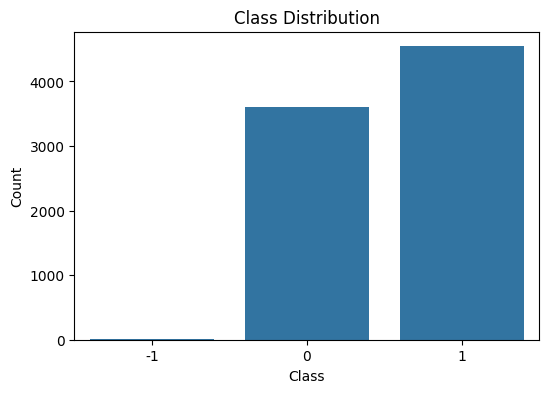

In [214]:
csv_1 = dpr.path.data.raw.data_mail.own.combined_own_csv
csv_2 = dpr.path.data.raw.data_mail.own.mails_labeled_csv
out_csv = dpr.path.data.raw.data_mail.own._path
combined_df = concat_and_save(csv_1, csv_2, out_csv, "mails_combined.csv")

### Mails from J. Mail Server

In [ ]:
from email.parser import BytesParser

In [ ]:
def extract_text_from_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup.get_text(separator='\n', strip=True)


def extract_email_data(email_file):
    encodings = ['utf-8', 'windows-1252', 'iso-8859-1']
    
    for enc in encodings:
        try:
            with open(email_file, 'rb') as f:
                msg = BytesParser(policy=policy.default).parse(f)

            sender = msg.get("From", None)
            subject = msg.get("Subject", None)
            to = msg.get("To", None)
            date = msg.get("Date", None)

            email_text = ""
            if msg.is_multipart():
                for part in msg.iter_parts():
                    if part.get_content_type() == 'text/plain':
                        email_text = part.get_payload(decode=True).decode(enc, errors='replace')
                        break
            else:
                if msg.get_content_type() == 'text/plain':
                    email_text = msg.get_payload(decode=True).decode(enc, errors='replace')

            email_text = email_text.replace('\r\n', '\n').replace('\r', '\n')
            return sender, subject, to, date, email_text.strip() if email_text.strip() else None

        except Exception as e:
            print(f"Failed to read {email_file} with encoding {enc}: {e}")
    
    return None, None, None, None, None

In [ ]:
def process_spam_folder(spam_folder_path, output_csv_path):
    email_data = []

    if not os.path.exists(spam_folder_path):
        print(f"Folder not found: {spam_folder_path}")
        return

    for root, dirs, files in os.walk(spam_folder_path):
        for file in files:
            email_file_path = os.path.join(root, file)
            sender, subject, to, date, body = extract_email_data(email_file_path)

            email_data.append([sender if sender else "", 
                               subject if subject else "", 
                               to if to else "", 
                               date if date else "", 
                               body if body else ""])

    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

    with open(output_csv_path, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Sender', 'Subject', 'Receiver', 'Date', 'Body'])
        writer.writerows(email_data)

    print(f"Data saved in: {output_csv_path}")

In [ ]:
def label_spam_csv(csv):
    df = pd.read_csv(csv)
    df['Label'] = 1

    df.to_csv(csv, index=False, encoding='utf-8')
    print(f"Labeled CSV saved to: {csv}")

##### Exectute on VM

In [ ]:
spam_folder = r"C:\\Users\\ilian\\Downloads\\spam"
output_csv = paths.data.raw.data_mail.own.jannis_mail_csv

In [ ]:
os.makedirs(spam_folder, exist_ok=True)
with open(os.path.join(spam_folder, 'test_sample.eml'), 'wb') as f:
    f.write(b"From: test@example.com\nTo: recipient@example.com\nSubject: Test Email with Umlauts\nDate: Fri, 16 Feb 2025 12:34:56 +0000\n\nHello, this is a test email with special characters like \xe4, \xfc, and \xf6.\nBest regards,\nTester")


In [ ]:
process_spam_folder(spam_folder, output_csv)

In [ ]:
label_spam_csv(output_csv)